# Regression and Prediction

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns
from dmba import stepwise_selection
from dmba import AIC_score

In [3]:
lung = pd.read_csv('../../data/LungDisease.csv')

## Simple Linear regression:
$Y = b_0 + b_1 X$  

- A regression equation models the relationship between a predictor ($X$) and a response variable ($Y$). The model gives predicted values (fitted values) and prediction errors (residuals).
- The model is typically created using the _least squares method_, which minimizes the sum of the squares of the residuals in a regression model.
- Regression is used for both prediction and explanation of data.


[]

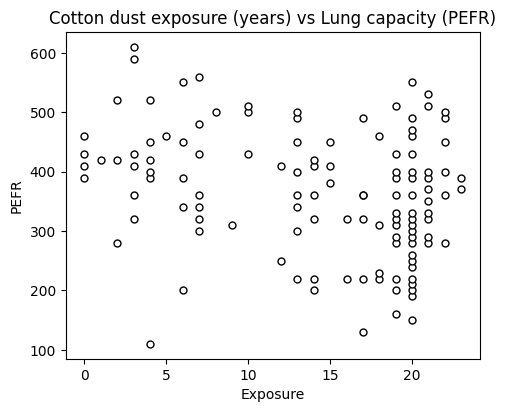

In [4]:
lung.plot.scatter(x='Exposure', y='PEFR', s=25, color='white', edgecolor='black', figsize=(5,4))
plt.tight_layout()
plt.title('Cotton dust exposure (years) vs Lung capacity (PEFR)')
plt.plot()

# in this case, PEFR = b0 + b1 Exposure

In [5]:
features = ['Exposure'] # x values, predictos (for matrix shaped)
target = 'PEFR' # y values, outcome

model = LinearRegression()
model.fit(lung[features], lung[target])

print(f'Intercept: {model.intercept_:.2f}')
print(f'Coefficient Exposure: {model.coef_[0]:.2f}')


Intercept: 424.58
Coefficient Exposure: -4.18


The intercept, or $b_0$, is 424.583 and can be interpreted as the predicted PEFR for a worker with zero years exposure. The regression coefficient, or $b_1$, can be interpreted as follows: for each additional year that a worker is exposed to cotton dust, the worker’s PEFR measurement is reduced by –4.185

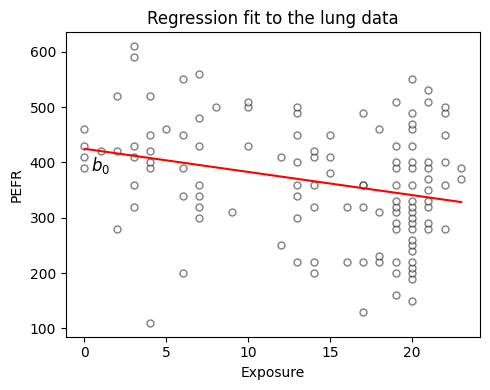

In [6]:
# Create a range of x values
x_range = [lung['Exposure'].min(), lung['Exposure'].max()]

# Calculate the corresponding y values for the line
y_range = model.intercept_ + model.coef_ * x_range

ax = lung.plot.scatter(x='Exposure', y='PEFR', s=25, color='white', edgecolor='black', figsize=(5,4), alpha=0.5)
ax.plot(x_range, y_range, color='r')
ax.text(0.4, model.intercept_-40, s=r'$b_0$', size='larger')
plt.title('Regression fit to the lung data')
plt.tight_layout()

In [7]:
# Fitted values, the prediction Y for each X
fitted = model.predict(lung[features])

# The error for each X (distance from Y value to predicted Y')
residuals = lung[target] - fitted

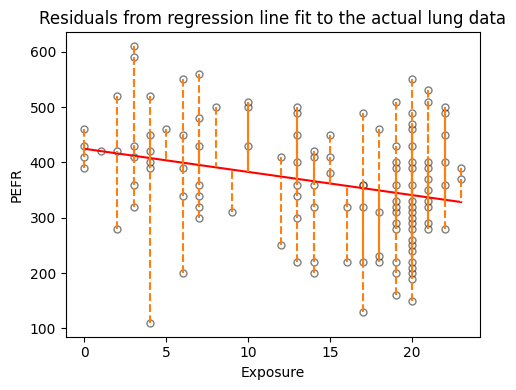

In [8]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', s=25, color='white', edgecolor='black', figsize=(5,4), alpha=0.5)
ax.plot(lung['Exposure'], fitted, color='r')

for x, y, y_fitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x,x), (y, y_fitted), '--', color='C1')

plt.title('Residuals from regression line fit to the actual lung data')
plt.tight_layout()

## Multiple Linear Regression

In [9]:
df = pd.read_csv('../../data/departamentos-en-venta-2020.csv')
apts_belgrano = df[df['Barrio'] == 'BELGRANO'][['Dolares', 'PropiedadS', 'Ambientes']]
apts_belgrano.columns = ['Price', 'm2', 'Rooms']

In [10]:
predictors = ['m2', 'Rooms'] # we could've had more variables, like bedrooms, restrooms, etc
target = 'Price'

apts_lm = LinearRegression()
apts_lm.fit(apts_belgrano[predictors], apts_belgrano[target])

LinearRegression()

In [11]:
print(f'Intercept:  {apts_lm.intercept_ : .3f}')

for var, coef in zip(predictors, apts_lm.coef_):
    print(f'Coef {var}: {coef : .3f}')

# predict price of apartments from Belgrano according to their surface (m2) and rooms

Intercept:  -8872.533
Coef m2:  4399.015
Coef Rooms: -23801.034


The interpretation of the coefficients in this multiple linear regression model is that the predicted Price changes by the coefficient value for each unit change in the corresponding predictor, assuming all other variables remain constant.  

- The coefficient for `m2` (4399.015) indicates that each additional square meter increases the estimated price by roughly 4399.015 dollars.
- The coefficient for `Rooms` (-23801.034) suggests that each additional room decreases the price by approximately 23801.034 dollars. These effects are independent of each other, holding all other variables constant. That is, holding the square meterage (m2) constant, each additional room is associated with a decrease in the apartment price.

Now, the same analysis but filtering out the outliers (since there are a few million dollars apartments).

In [12]:
# IQR for the Price column
Q1, Q3 = apts_belgrano['Price'].quantile(0.25), apts_belgrano['Price'].quantile(0.75)
IQR = Q3 - Q1

# Bounds for Price outliers (1.5 x IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_apts_belgrano = apts_belgrano[(apts_belgrano['Price'] >= lower_bound) &
                                       (apts_belgrano['Price'] <= upper_bound)]

apts_filt_lm = LinearRegression()
apts_filt_lm.fit(filtered_apts_belgrano[predictors], filtered_apts_belgrano[target])

print(f'Intercept:  {apts_filt_lm.intercept_ : .3f}')

for var, coef in zip(predictors, apts_filt_lm.coef_):
    print(f'Coef {var}: {coef : .3f}')

Intercept:   30191.181
Coef m2:  2060.522
Coef Rooms:  21378.799


Root Mean Squared Error (RMSE): It measures the average difference between actual and predicted prices. Lower RMSE indicates better model accuracy.

R-squared (r2) or Coefficient of Determination: It indicates how well the model explains the variance in actual prices, useful mainly in explanatory uses of regression where you want to assess how well the model fits the data. An R-squared closer to 1 means better explanatory power.

In [13]:
fitted = apts_filt_lm.predict(filtered_apts_belgrano[predictors])
RMSE = np.sqrt(mean_squared_error(filtered_apts_belgrano['Price'], fitted))
r2 = r2_score(filtered_apts_belgrano['Price'], fitted)

print(f'RMSE: {RMSE:.3f}')
print(f'r2: {r2:.3f}')

RMSE: 68954.929
r2: 0.725


In [14]:
model_explained = sm.OLS(filtered_apts_belgrano[target], filtered_apts_belgrano[predictors].assign(const=1))
results = model_explained.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                 1.354e+04
Date:                Thu, 27 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:27:30   Log-Likelihood:            -1.2927e+05
No. Observations:               10292   AIC:                         2.585e+05
Df Residuals:                   10289   BIC:                         2.586e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
m2          2060.5224     23.216     88.753      0.0

An **RMSE** of 68954.929 means the predictions are off (deviate) by about 68954.929 units on average.  

An **R^2** of 0.725 means the model explains 72.5% of the variation in apartment prices. Alternatively, we can say that `rooms` and `m2` explain 72.5% of the variation on `price`.   

The **null hypothesis in the context of a t-test in regression analysis** is typically that the coefficient for a certain predictor variable is equal to zero. This implies that the predictor has no effect on the outcome variable (example: H0 for m2, the coefficient for `m2` is 0, meaning `m2` has no effect on `Price`).  

The **p-value** in this model tells us the probability that you would see a t-statistic as extreme as the one you got if the null hypothesis were true (i.e., the coefficient is actually 0). A small p-value (typically ≤ 0.05) indicates strong evidence that the coefficient is different from 0. In this case, the p-values for `m2`, `Rooms`, and ‘const’ are all 0.000 (< 0.05), so we **reject the null hypothesis**, indicating that these **predictors are statistically significant**.

## Model Selection and Stepwise Regression

- Multiple predictors can be included in regression models.

- Occam’s Razor: Prefer simpler models over more complex ones if they perform equally well. This guides variable selection.

- Adjusted R² and AIC: Metrics like RMSE and R² are not reliable for model choice. Adjusted R² and Akaike’s Information Criteria (AIC) account for model complexity and are better indicators.

- **Stepwise Regression**: Practical method including backward elimination (removing insignificant variables) and forward selection (adding significant variables).

In [2]:
lands_caba = pd.read_csv('../../data/Terrenos-en-venta-2020.csv')
del lands_caba['DIRECCION'], lands_caba['PRECIOPESO'], lands_caba['DOLARM2'], lands_caba['PESOSM2']
lands_caba[0:5]

,SUPERFICIE,PRECIOUSD,COTIZACION,TRIMESTRE_,BARRIO,COMUNA_
0,190,150000,80,CUARTO,ALMAGRO,5
1,242,230000,80,CUARTO,ALMAGRO,5
2,211,265000,80,CUARTO,ALMAGRO,5
3,320,300000,80,CUARTO,ALMAGRO,5
4,250,305000,80,CUARTO,ALMAGRO,5


#### Factor variables

For P distinct values of a factor variable (like `Barrio`) are represented with P-1 dummy variables (to avoid **multicollinearity**, a condition in which there is redundance among the predictor variables)

In [3]:
# One-hot codification, turn categorical variables into numeric
lands_caba = pd.get_dummies(lands_caba, columns=['TRIMESTRE_', 'BARRIO', 'COMUNA_'], drop_first=True, dtype=int)
lands_caba

,SUPERFICIE,PRECIOUSD,COTIZACION,TRIMESTRE__PRIMER,TRIMESTRE__SEGUNDO,TRIMESTRE__TERCER,BARRIO_ALMAGRO,BARRIO_BALVANERA,BARRIO_BARRACAS ESTE,BARRIO_BARRACAS OESTE,...,COMUNA__6,COMUNA__7,COMUNA__8,COMUNA__9,COMUNA__10,COMUNA__11,COMUNA__12,COMUNA__13,COMUNA__14,COMUNA__15
0,190,150000,80,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,242,230000,80,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,211,265000,80,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,320,300000,80,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,250,305000,80,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10296,149,430000,64,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10297,500,790000,64,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10298,771,690000,64,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10299,409,800000,64,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [4]:
# define target
outcome = 'PRECIOUSD'
Y = lands_caba[outcome]

# predictos
predictors = lands_caba.columns.to_list()
predictors.remove('PRECIOUSD')

# to evaluate
X = lands_caba[predictors]

In [18]:
# Function that returns a fitted model for a given set of variables
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], Y)
    return model

# Function that returns a score for a given model and set of variables. In this case, we use the AIC_score implemented in the dmba package.
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(Y, [Y.mean()] * len(Y), model, df=1)
    return AIC_score(Y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model,
                                                score_model, verbose=True)

print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')
r2 = r2_score(Y, best_model.predict(X[best_variables]))

Variables: SUPERFICIE, COTIZACION, TRIMESTRE__PRIMER, TRIMESTRE__SEGUNDO, TRIMESTRE__TERCER, BARRIO_ALMAGRO, BARRIO_BALVANERA, BARRIO_BARRACAS ESTE, BARRIO_BARRACAS OESTE, BARRIO_BELGRANO, BARRIO_BOCA, BARRIO_BOEDO, BARRIO_CABALLITO, BARRIO_CHACARITA, BARRIO_COGHLAN, BARRIO_COLEGIALES, BARRIO_CONSTITUCION, BARRIO_FLORES NORTE, BARRIO_FLORES SUR, BARRIO_FLORESTA, BARRIO_LINIERS, BARRIO_MATADEROS, BARRIO_MONTE CASTRO, BARRIO_MONTSERRAT, BARRIO_NUEVA POMPEYA, BARRIO_NUÑEZ, BARRIO_PALERMO, BARRIO_PARQUE AVELLANEDA, BARRIO_PARQUE CHACABUCO, BARRIO_PARQUE CHAS, BARRIO_PARQUE PATRICIOS, BARRIO_PATERNAL, BARRIO_PUERTO MADERO, BARRIO_RECOLETA, BARRIO_RETIRO, BARRIO_SAAVEDRA, BARRIO_SAN CRISTOBAL, BARRIO_SAN NICOLAS, BARRIO_SAN TELMO, BARRIO_VELEZ SARSFIELD, BARRIO_VERSALLES, BARRIO_VILLA CRESPO, BARRIO_VILLA DEL PARQUE, BARRIO_VILLA DEVOTO NORTE, BARRIO_VILLA DEVOTO SUR, BARRIO_VILLA GRAL. MITRE, BARRIO_VILLA LUGANO, BARRIO_VILLA LURO, BARRIO_VILLA ORTUZAR, BARRIO_VILLA PUEYRREDON, BARRIO_VILLA

In [19]:

not_used_variables = [var for var in predictors if not var in best_variables]

# The dropped variables do not provide additional useful information for prediction, at least not enough to justify their inclusion in the model based on the selection 

print(f"The variables that were dropped from the model are: {not_used_variables}\n")
print(f"The R2 value of the best model is {r2},\nwhich means that the chosen variables (the most significant) explain approximately {round(r2*100,-1)}% of the variation in land prices")

The variables that were dropped from the model are: ['COTIZACION', 'TRIMESTRE__SEGUNDO', 'BARRIO_BOCA', 'BARRIO_COLEGIALES', 'BARRIO_FLORESTA', 'BARRIO_LINIERS', 'BARRIO_MATADEROS', 'BARRIO_MONTE CASTRO', 'BARRIO_NUEVA POMPEYA', 'BARRIO_NUÑEZ', 'BARRIO_PARQUE AVELLANEDA', 'BARRIO_PARQUE CHACABUCO', 'BARRIO_PARQUE CHAS', 'BARRIO_PARQUE PATRICIOS', 'BARRIO_PATERNAL', 'BARRIO_SAN CRISTOBAL', 'BARRIO_VELEZ SARSFIELD', 'BARRIO_VILLA DEL PARQUE', 'BARRIO_VILLA GRAL. MITRE', 'BARRIO_VILLA LUGANO', 'BARRIO_VILLA LURO', 'BARRIO_VILLA PUEYRREDON', 'BARRIO_VILLA REAL', 'BARRIO_VILLA RIACHUELO', 'BARRIO_VILLA SANTA RITA', 'COMUNA__2', 'COMUNA__3', 'COMUNA__4', 'COMUNA__5', 'COMUNA__6', 'COMUNA__7', 'COMUNA__10', 'COMUNA__11', 'COMUNA__12', 'COMUNA__14', 'COMUNA__15']

The R2 value of the best model is 0.49323025356105954,
which means that the chosen variables (the most significant) explain approximately 50.0% of the variation in land prices


Here an example to predict the value of a land price (USD) using the provided regression model. Let's say we have a estate with the following characteristic:
- Palermo
- 150m²
- Comuna 13
- 3rd trimester

So the predicted price will be:

In [20]:
my_land = {var:0 for var in best_variables}

my_land['SUPERFICIE'] = 150
if 'BARRIO_PALERMO'in best_variables:
    my_land['BARRIO_PALERMO'] = 1
if 'COMUNA__13'in best_variables:
    my_land['COMUNA__13'] = 1
if 'TRIMESTRE__TERCER' in best_variables:
    my_land['TRIMESTRE__TERCER'] = 1

predicted_value = best_model.intercept_
for (key,value), coef in zip(my_land.items(), best_model.coef_):
    if value:
        print(key, coef)
    predicted_value += coef * value

predicted_value

SUPERFICIE 917.0725065141947
BARRIO_PALERMO 741483.8108189534
COMUNA__13 562334.4625428822
TRIMESTRE__TERCER -89511.85504661319


1604632.567230867

## Prediction using Regression

In [25]:
lands_price_area = lands_caba[['PRECIOUSD', 'SUPERFICIE']]
predictor = ['SUPERFICIE']
outcome = 'PRECIOUSD'

lm_lands = LinearRegression()
lm_lands.fit(lands_price_area[predictor], lands_price_area[outcome])

LinearRegression()

So we are gonna draw the prediction interval of the fitted line as the formula:

$$\text{PI} = \hat{y} \pm Z_{0.975} \cdot \sigma_{\text{residuals}}$$



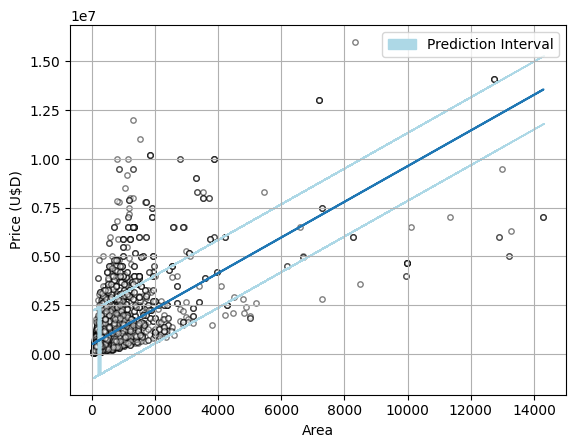

In [84]:
plt.scatter(lands_price_area[predictor], lands_price_area[outcome], color='white', edgecolor='black', alpha=0.5, s=15)

predictions = lm_lands.predict(lands_price_area[predictor])
plt.plot(lands_price_area[predictor], predictions)

# prediction interval: X = Zscore for 95% conf * std(residuals)
prediction_interval = 1.96 * np.std(lands_caba[outcome] - predictions)
plt.fill_between(lands_price_area[predictor].values.flatten(),
                 predictions - prediction_interval, predictions + prediction_interval,
                 color='lightblue', label='Prediction Interval')
plt.xlabel('Area')
plt.ylabel('Price (U$D)')
plt.legend()
plt.grid(True)
plt.show()

### Interactions between predictors

- Correlation between predictors affects coefficient interpretation in multiple linear regression.
- Multicollinearity can cause numerical instability during regression fitting.
- Omitting an important predictor (confounding variable) can lead to spurious relationships.
- Interaction terms are necessary when variables’ relationship with the response is interdependent. 

In [4]:
# keep only sold lands from Palermo
lands_palermo = lands_caba.loc[lands_caba['BARRIO_PALERMO']==1]
lands_palermo = lands_palermo[['PRECIOUSD', 'SUPERFICIE', 'BARRIO_PALERMO']]
lands_palermo


,PRECIOUSD,SUPERFICIE,BARRIO_PALERMO
127,9500000,868,1
128,280000,288,1
129,9500000,868,1
130,98000,30,1
131,370000,507,1
...,...,...,...
9863,730000,211,1
9864,1099900,388,1
9865,595000,251,1
9866,1000000,225,1


In [23]:
# As we saw in the last plot (the one of the dataframe only being Area x Price), there are many outliers in Area. lets get rid of them

In [5]:
predictor = ['SUPERFICIE']
outcome = 'PRECIOUSD'

# ordinary least squares regression model
lands_outliers = sm.OLS(lands_palermo[outcome], lands_palermo[predictor].assign(const=1))
results_palermo = lands_outliers.fit()

In [6]:
# We extract the standardized residuals and obtain the index of the smallest residual

influence = OLSInfluence(results_palermo) # instance to get influence and outlier measures for the fitted model
sresiduals = influence.resid_studentized_internal # calculates the studentized residuals
sresiduals.idxmin(), sresiduals.min() # index and value of the minimum studentized residual

(886, -2.596470715325824)

In [8]:
outlier = lands_palermo.loc[sresiduals.idxmin(), :]
print('Price of the outlier: ', outlier[outcome])
print('Area of the outlier:' , outlier[predictor[0]])

Price of the outlier:  1290000
Area of the outlier: 2400


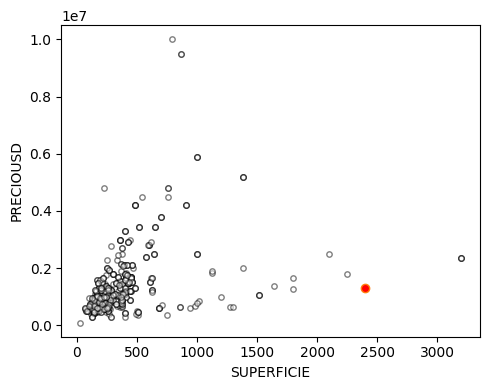

In [24]:
lands_palermo.plot.scatter('SUPERFICIE', 'PRECIOUSD', color='white', edgecolor='black', alpha=0.5, s=15, figsize=(5,4))
plt.scatter(outlier[predictor[0]], outlier[outcome], color='red', edgecolor='C1')
plt.tight_layout()

Outliers are not a major concern in regression for predicting new data in big data contexts. However, in **anomaly detection**, detecting outliers is essential, as they can indicate fraud or other critical anomalies, fulfilling a vital business need.

#### Influence Plot

A plot to determine which observations have high influence; points with Cook’s distance greater than 0.08 are above and below the orange lines.

It shows the relationship between studentized residuals (standardized residuals) and leverage (hat values).
- Large studentized residuals indicate potential outliers.
- Leverage (Hat Values): Leverage measures how much a data point influences its own prediction. High leverage points have extreme predictor values.
- Cook’s Distance: The size of each point in the scatter plot corresponds to Cook’s distance, which quantifies the influence of each observation on the regression coefficients. Larger points indicate more influential observations.
- Horizontal Dashed Lines: The orange dashed lines at -2.5 and 2.5 represent typical cutoffs for identifying outliers based on studentized residuals. Points outside these lines may be considered outliers.

Text(0, 0.5, 'Studentized residuals')

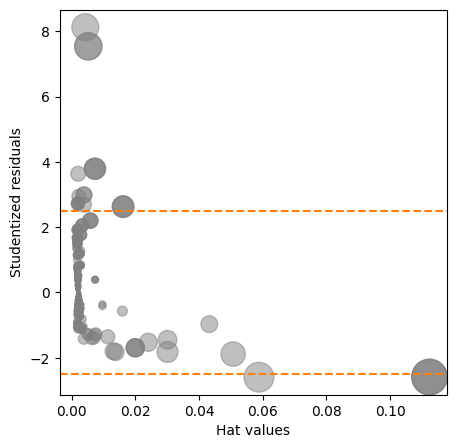

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
           s=1000 * np.sqrt(influence.cooks_distance[0]), alpha=0.5, color="grey")
ax.set_xlabel('Hat values')
ax.set_ylabel('Studentized residuals')


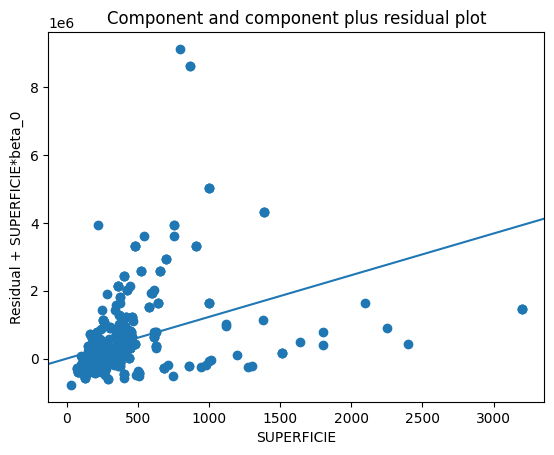

In [42]:
sm.graphics.plot_ccpr(results_palermo, 'SUPERFICIE')
plt.show()

 This scatter plot shows a linear relationship between the predictor variable (area) and the sum of residuals and area values. Small residuals are in the origin cluster data points. As surface area increases, the spread of residuals widens. The upward trend of the regression line suggests that larger surface areas tend to have higher residual sums. However, the increasing spread could indicate **heteroskedasticity** (non-constant variance in residuals). 